# Self-Driving Car Engineer Nanodegree


## Project 2 : **Advanced Lane Finding** 
***

## a) Pipeline:

    1) Compute the camera calibration matrix and distortion coefficients.
    2) Apply a distortion correction to raw images.
    3) Use color transforms to create a thresholded binary image.
    4) Apply a perspective transform to rectify binary image ("birds-eye view").
    5) Detect lane pixels and fit to find the lane boundary.
    6) Determine the curvature of the lane and vehicle position with respect to center.
    7) Warp the detected lane boundaries back onto the original image.
    8) Output lane boundaries and numerical estimation of lane curvature and vehicle position.
    9) Video processing

## 1) Compute the camera calibration matrix and distortion coefficients.

### a) find corners

First operation is to find pattern in chess board.
Once we find the corners, we can increase their accuracy using cv.cornerSubPix(). We can also draw the pattern using cv.drawChessboardCorners().

Source: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [1]:
import os, glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Take as input a list of chessboard images and number of corners x and y
def camera_calibration(images, nx, ny):
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images_corners_detected = []
    
    #Loop all the images
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            # Store in a new list the corner Sub Pix
            corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1), criteria)
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            images_corners_detected.append(img)   
    return objpoints, imgpoints, images_corners_detected

In [2]:
objpoints, imgpoints, images = camera_calibration(glob.glob('camera_cal/*jpg'), 9, 6)

chess_distorted = mpimg.imread(glob.glob('camera_cal/*jpg')[1])

### b) undistort images

As soon as corners are identified, it is possible to calibrate the camera and undistort the images using the calibration matrix calculated during the calibration

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

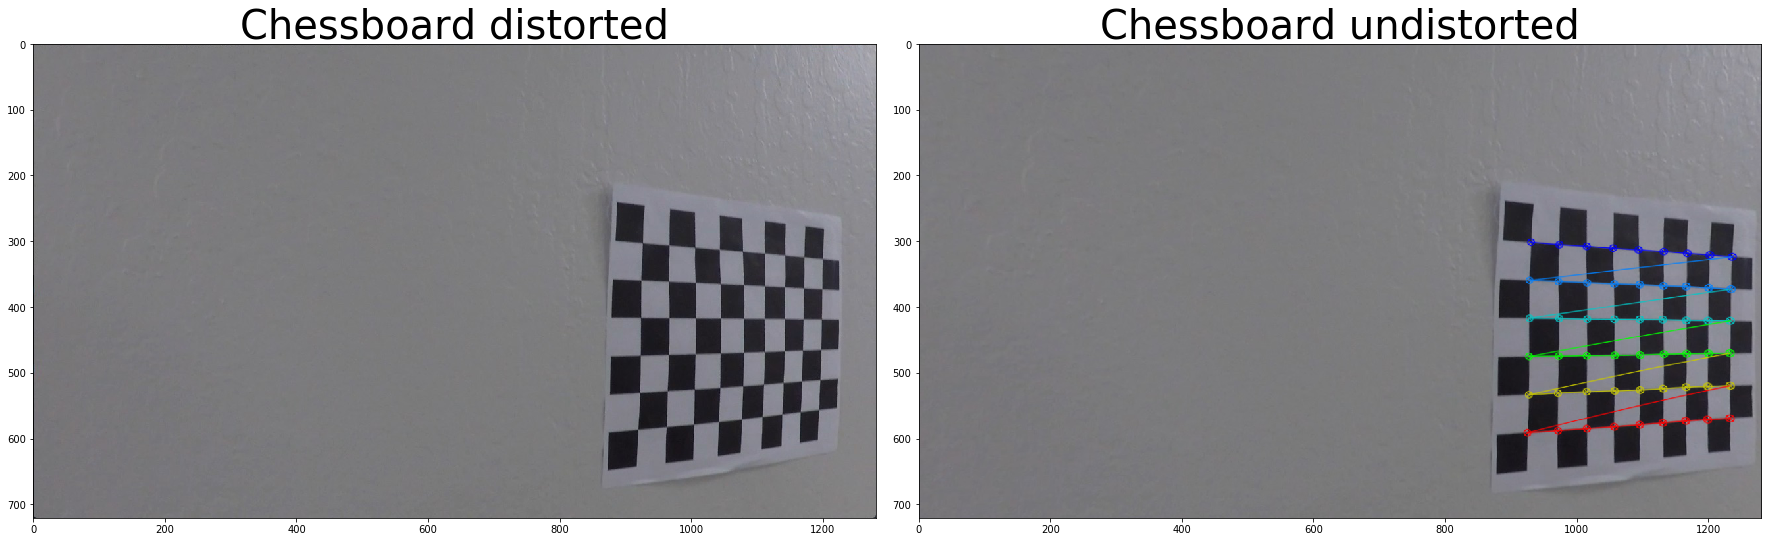

In [4]:
chess_undistorted  = cal_undistort(images[1], objpoints, imgpoints)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(chess_distorted)
ax1.set_title('Chessboard distorted', fontsize=40)

ax2.imshow(chess_undistorted)
ax2.set_title('Chessboard undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2) Apply a distortion correction to road test images.

Now that the calibration matrix is available, it is possible to apply it also to some test images 

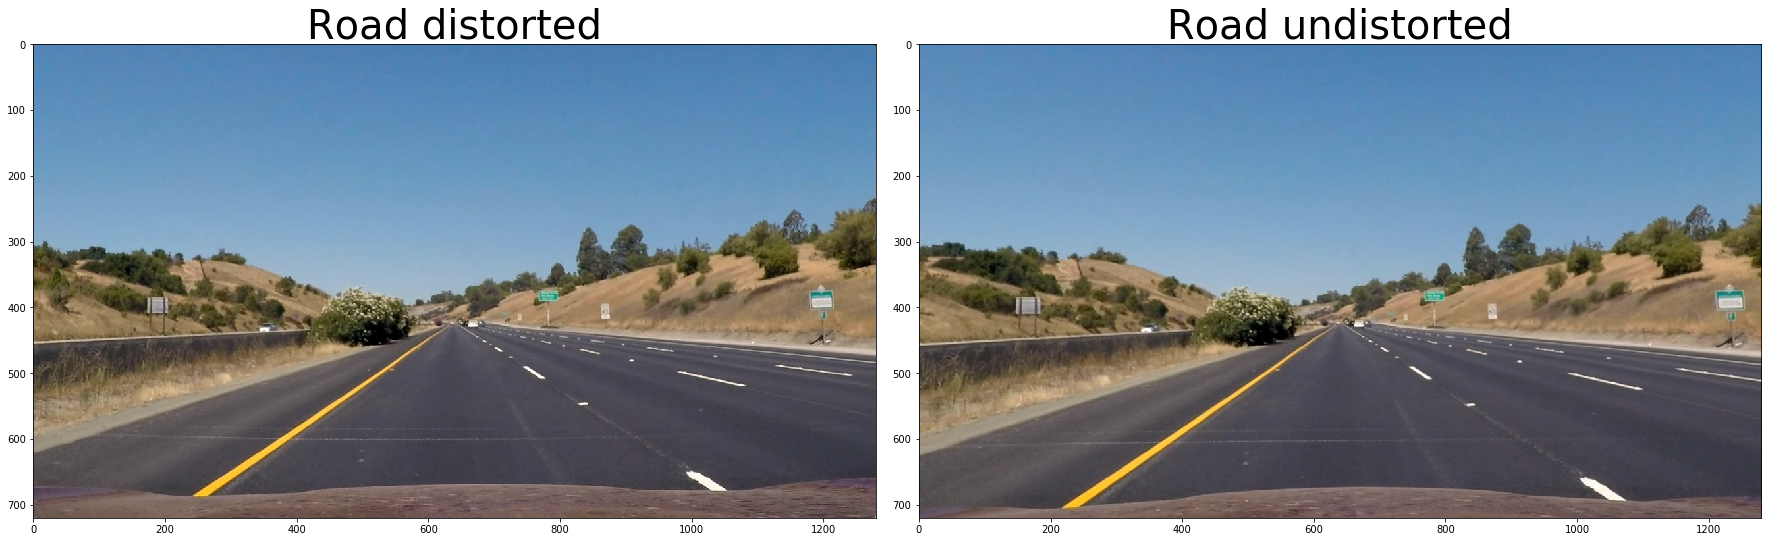

In [5]:
road_distorted = mpimg.imread(glob.glob('test_images/*jpg')[0])
road_undistorted = cal_undistort(road_distorted, objpoints, imgpoints)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_distorted)
ax1.set_title('Road distorted', fontsize=40)

ax2.imshow(road_undistorted)
ax2.set_title('Road undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3) Use color transforms to create a thresholded binary image.

In order to create a satisfying thresholded binary image, color thresholding on the s channel is created.
That is because color thresholds (using HLS space) help to detect lane lines of different colors and under different lighting conditions.
It is possible then to mask the image in order to extract the information needed.

In [6]:
def combine_threshold(img, s_thresh=(180, 255), sx_thresh=(20, 100)):
    # Saturation Filters
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hls[:,:,2]
    
    # Color Filters
    low_white = np.array([0, 0, 225], dtype=np.uint8)
    high_white = np.array([90,70,255], dtype=np.uint8)
    low_yellow = np.array([14,120,220], dtype=np.uint8)
    high_yellow = np.array([30,255,255], dtype=np.uint8)
    
    # Source https://github.com/glaumarkus/AD_PolynomialLaneMarkers/blob/master/Advanced%20Lane%20Detection.ipynb
    
    s_mask = cv2.inRange(s_channel, s_thresh[0], s_thresh[1])

    white_mask = cv2.inRange(hls, low_white, high_white)
    yellow_mask = cv2.inRange(hls, low_yellow, high_yellow)
    
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    binary = cv2.bitwise_or(color_mask, s_mask)

    return binary


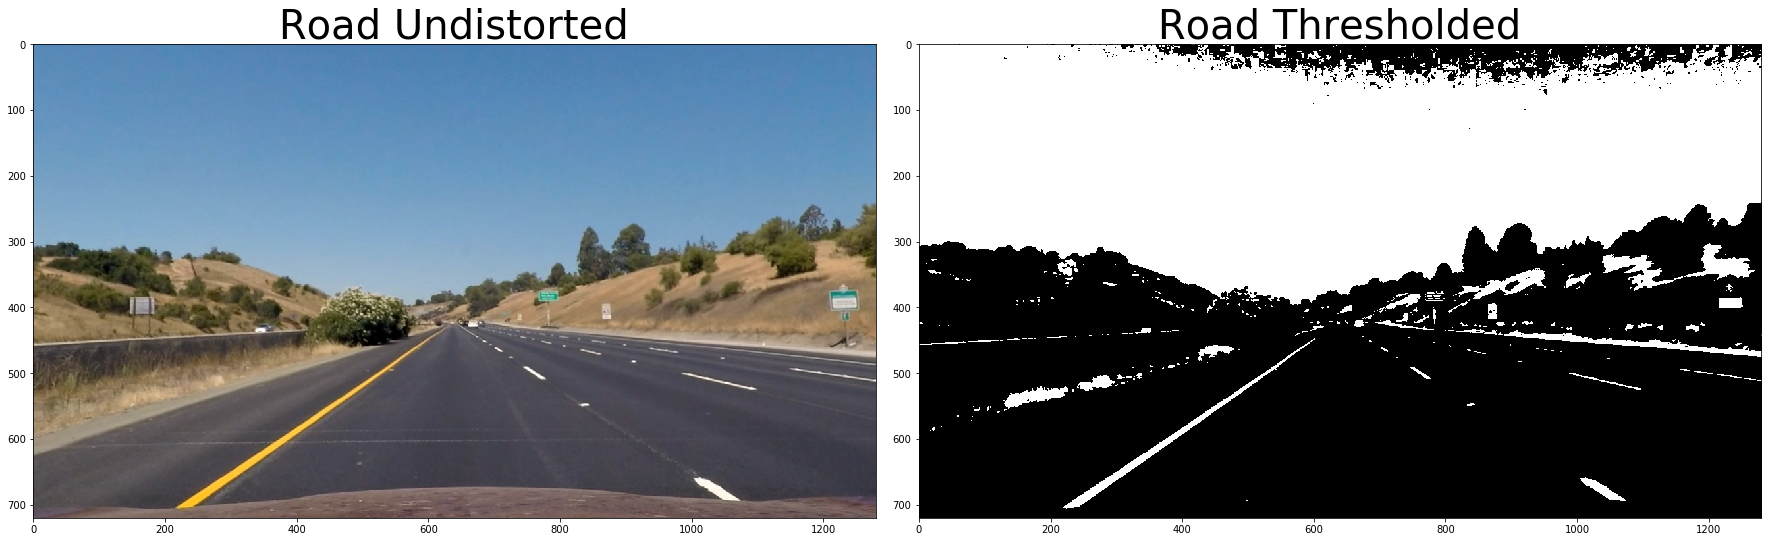

In [7]:
image_thresholded = combine_threshold(road_undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_undistorted)
ax1.set_title('Road Undistorted', fontsize=40)

ax2.imshow(image_thresholded, cmap='gray')
ax2.set_title('Road Thresholded', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4) Apply a perspective transform to rectify binary image ("birds-eye view").

Next, it is necessary to perform perspective transform. This is because of the phenomen of perspective, that let object to appear smaller the further they are from the viewpoint. Perspective applies also to lines, letting parallel lines to appear to converge to a point.
A perspective transorm warps the image and effectively drags point towards or away from the viewpoint in order to change the apparent perspective.

In order to do this in the image proposed, first the region of interest need to be exctracted, identifying four source points. Then, the four destination points are defined and the tranformation MAtrix M is calculated.
The region of interested will be an isosceles trapezoid, warped into a rectangle.

In [8]:
def warp_image(img, src_points, dest_points):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    # Warp the image using OpenCV warpPerspective()
    # Source https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped

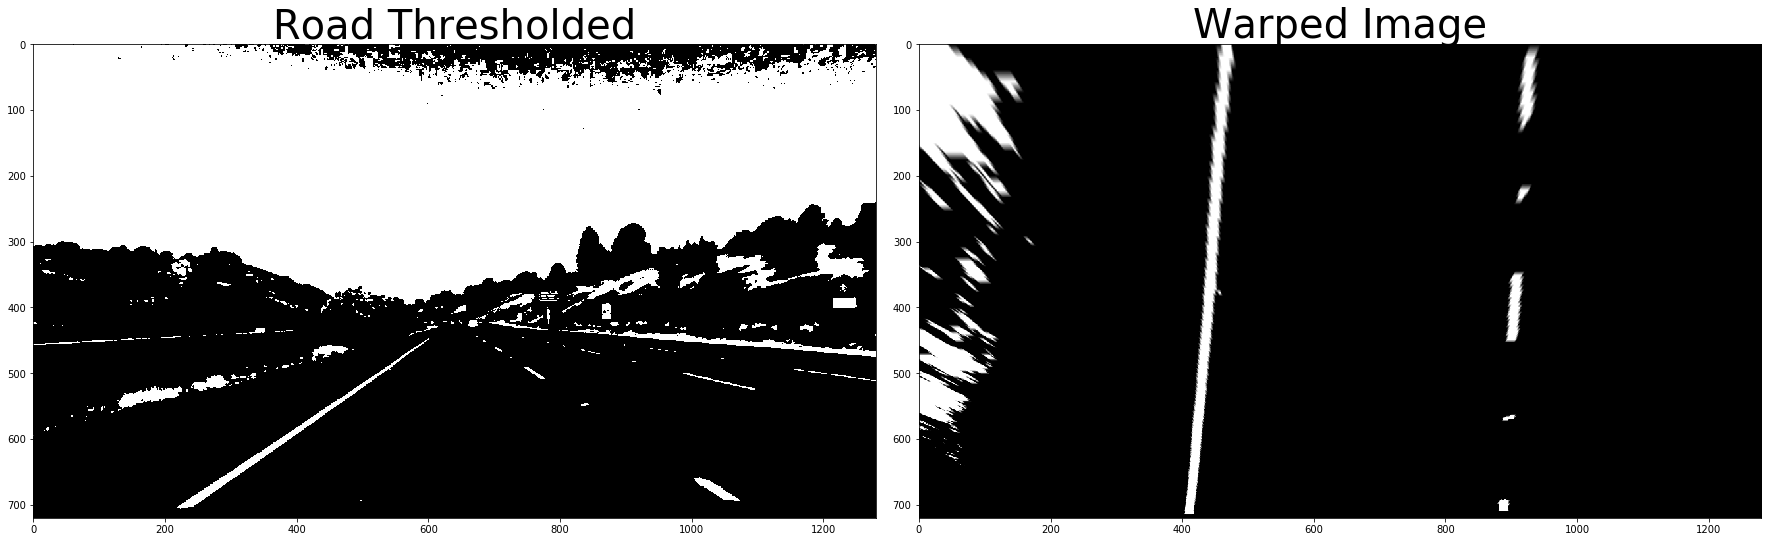

In [9]:
# Isoscel Trapezoid 
src_points = np.float32([[150,720], # bottom left
 [1130, 720], # bottom right
 [500,460], # top left
 [740, 460]]) # top right
dest_points = np.float32([[380,720],
 [900, 720],
 [150,0],
 [1080, 0]])

warped_image = warp_image(image_thresholded, src_points, dest_points)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_thresholded, cmap='gray')
ax1.set_title('Road Thresholded', fontsize=40)

ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5) Detect lane pixels and fit to find the lane boundary.

At this point, it is necessary to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this.
The two highest peaks from the histogram are used a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

In [10]:
def find_lane_pixels(warped_image):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    image_lanes = np.dstack((warped_image, warped_image, warped_image))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(image_lanes,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(image_lanes,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, image_lanes


def fit_polynomial(warped_image):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, image_lanes = find_lane_pixels(warped_image)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    image_lanes[lefty, leftx] = [255, 0, 0]
    image_lanes[righty, rightx] = [0, 0, 255]

    return image_lanes, left_fit, right_fit, ploty, leftx, lefty, rightx, righty

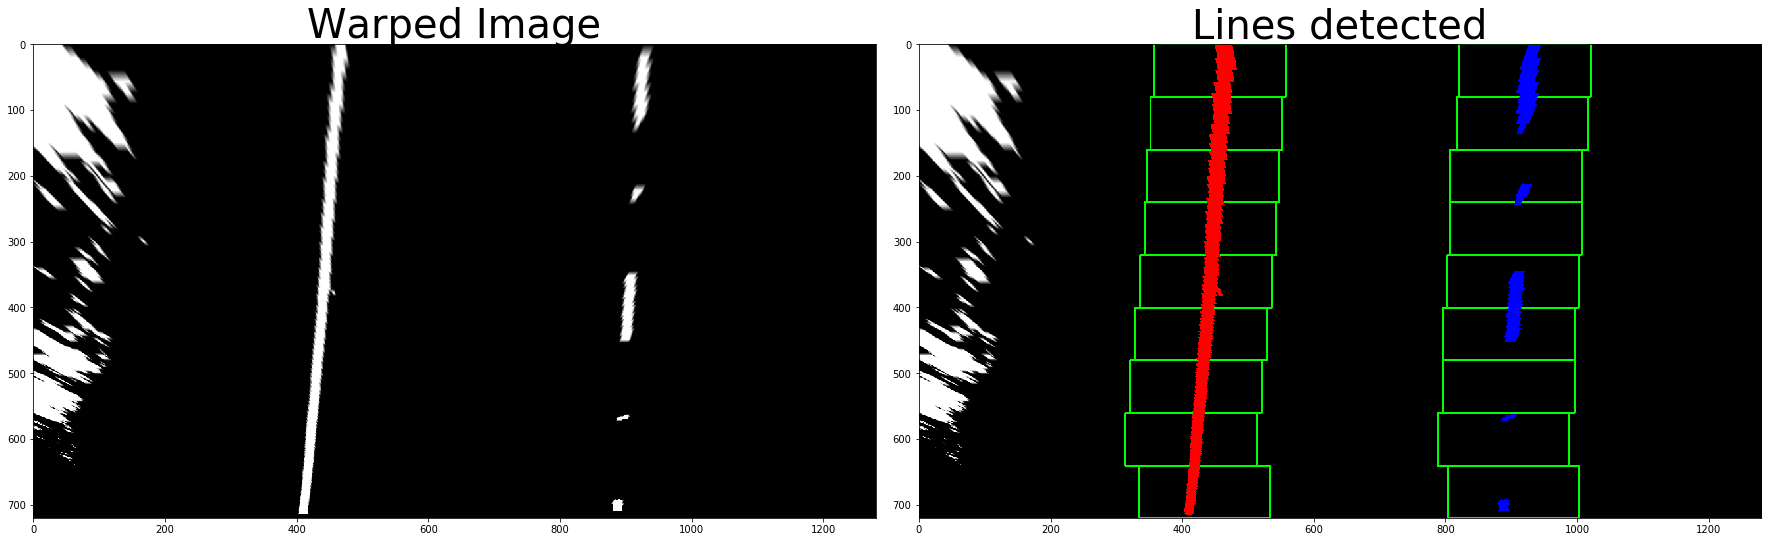

In [11]:
image_lanes, left_fit, right_fit, ploty, leftx, lefty, rightx, righty = fit_polynomial(warped_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_image, cmap='gray')
ax1.set_title('Warped Image', fontsize=40)

ax2.imshow(image_lanes)
ax2.set_title('Lines detected', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 6) Determine the curvature of the lane and vehicle position with respect to center.

Once the two lines are identified, next step is to calculate the radius of the curvature and the distance from the center of the road. 
This is a measure of the quality of the steps followe and it can give feedback thinking about real data.
The U.S. regulations require a minimum lane width of of 3.7 meters, so knowing the shape of our image we can extract the correspondence between pixels and meters in the image.

In [12]:
def measure_curvature_real(left_fit, right_fit, ploty, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # Maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    
    # Calculation of R_curve (radius of curvature)
    # https://www.intmath.com/applications-differentiation/8-radius-curvature.php
    left_R_curve = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_R_curve = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Mean value
    
    R_curve = np.float32((left_R_curve + right_R_curve)/2)
    
    return R_curve


In [13]:
def measure_distance_from_center(leftx, lefty, rightx, righty, center):
        
        left_fit = np.polyfit(lefty, leftx, 2)
        left_x = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_x = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
        
        center_lane = np.float32((right_x + left_x) / 2)
        
        m_per_pixel = 3.7 / 1000
    
        distances_from_center = np.float32(np.abs(center - center_lane) * m_per_pixel)
        
        distance_from_center = 0
        distance_sum = 0
        i = 0
        
        for i in range(distances_from_center.shape[0]):
            distance_sum += distances_from_center[i]
            
        distance_from_center = distance_sum/i
        return distance_from_center

In [14]:
R_curve = measure_curvature_real(left_fit, right_fit, ploty, leftx, lefty, rightx, righty)
center = (road_distorted.shape[0] / 2)
distance_from_center = measure_distance_from_center(leftx, lefty, rightx, righty, center)
print(distance_from_center)

1.12801505272


## 7) Warp the detected lane boundaries back onto the original image.

It is now time to put all the measures done so far on the original image. Radius of the curve, distance from the center of the lane and the two lines are available.
An area representing the lane is displayed together with the indications of Radius and distance.

In [15]:
def warped_draw_lane(warped_image, left_fit, right_fit, ploty):
    
    lane_drawn = np.zeros_like(np.dstack((warped_image, warped_image, warped_image))*255)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Plots the left and right polynomials on the lane lines
    left_lane = np.vstack((left_fitx, ploty)).T.astype(np.int32)
    right_lane = np.vstack((right_fitx, ploty)).T.astype(np.int32)
    area = np.concatenate((left_lane, right_lane[::-1]))

    cv2.polylines(lane_drawn, [left_lane], isClosed=False, color=(203,50,52), thickness=40)
    cv2.polylines(lane_drawn, [right_lane], isClosed=False, color=(203,50,52), thickness=50)
    cv2.fillConvexPoly(lane_drawn, area, color=(127,255,212))
    #Source: https://github.com/glaumarkus/AD_PolynomialLaneMarkers/blob/master/Advanced%20Lane%20Detection.ipyn
    return lane_drawn
    

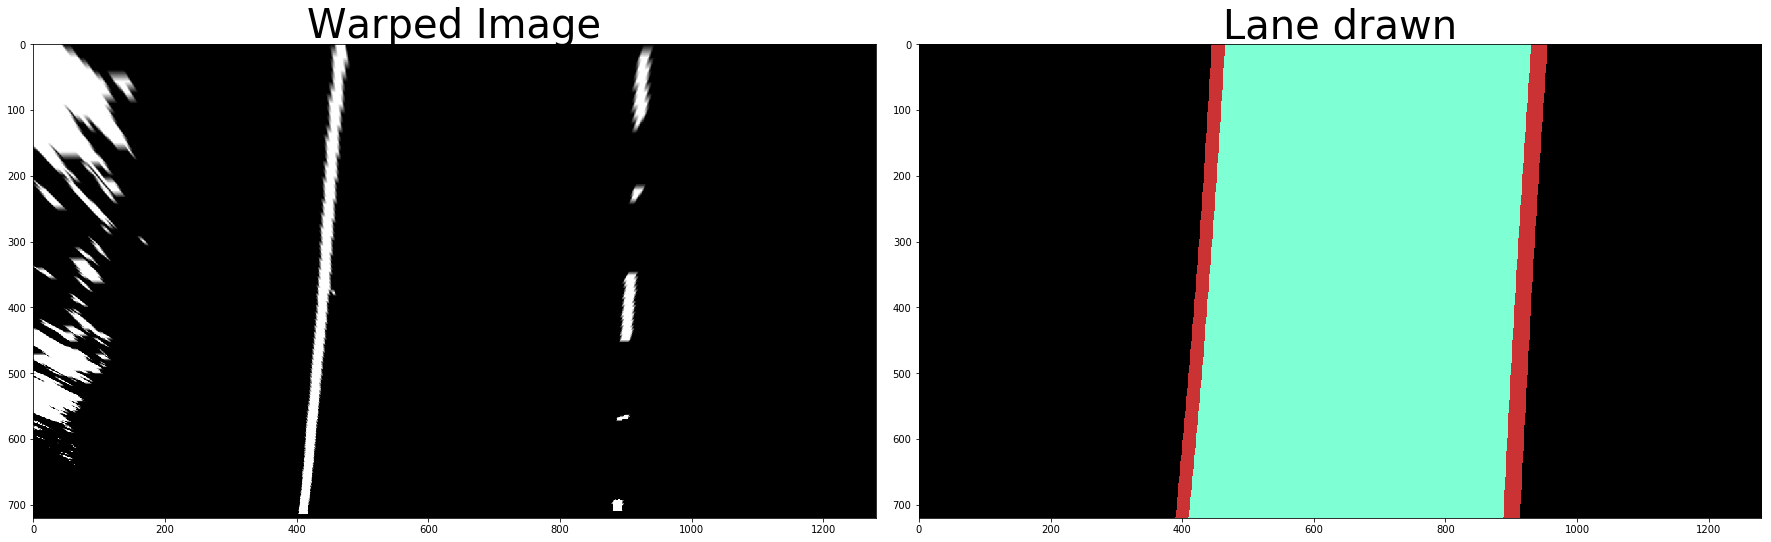

In [16]:
warped_lane_drawn = warped_draw_lane(warped_image, left_fit, right_fit, ploty)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_image, cmap='gray')
ax1.set_title('Warped Image', fontsize=40)

ax2.imshow(warped_lane_drawn)
ax2.set_title('Lane drawn', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 8) Output lane boundaries and numerical estimation of lane curvature and vehicle position.

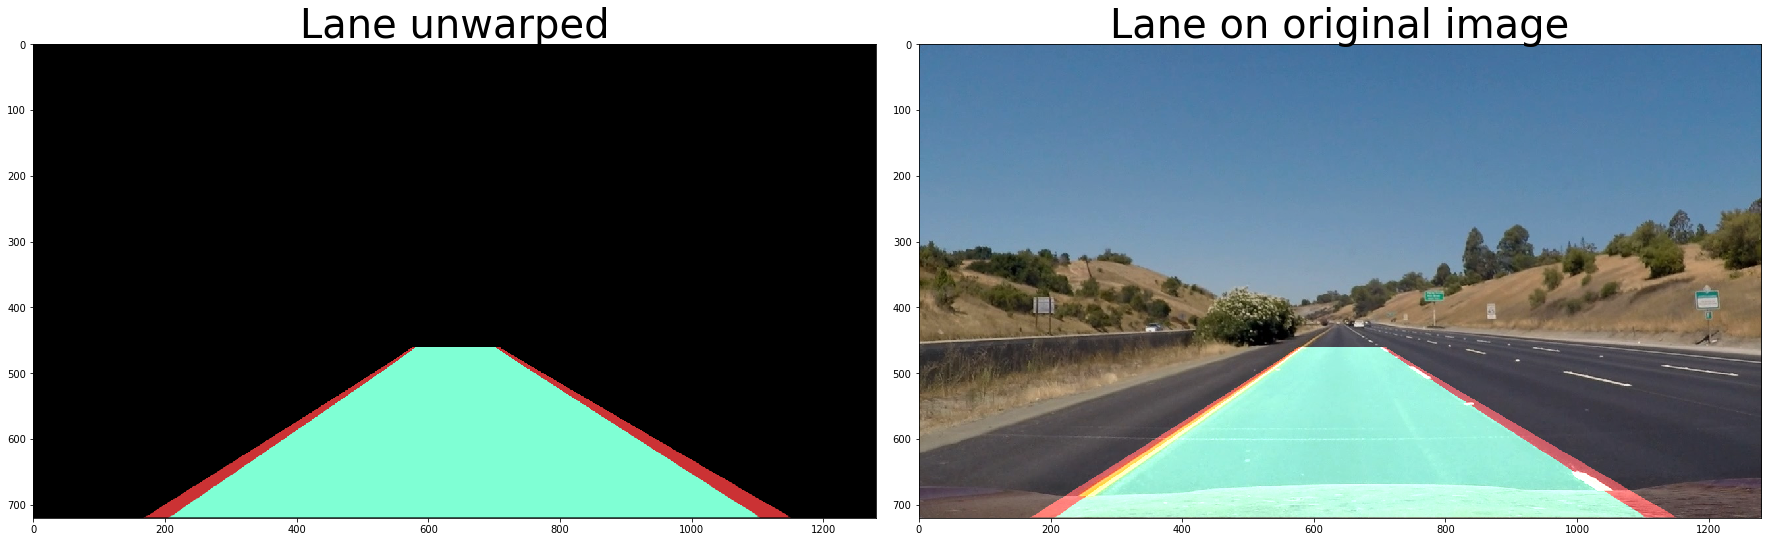

In [17]:
lane_drawn = warp_image(warped_lane_drawn, dest_points, src_points)
road_lane = cv2.addWeighted(road_distorted,0.9,lane_drawn,.7,0)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(lane_drawn, cmap='gray')
ax1.set_title('Lane unwarped', fontsize=40)

ax2.imshow(road_lane)
ax2.set_title('Lane on original image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
def draw_radius_center(img, R_curve, distance_from_center):
    output_image = img.copy()
    cv2.putText(output_image, 'Radius of curvature is {:.2f}m'.format(R_curve),(50, 70),cv2.FONT_HERSHEY_DUPLEX,2,(255, 255, 255),2)
    cv2.putText(output_image, 'Distance from center is {:.2f}m'.format(distance_from_center),(50, 140),cv2.FONT_HERSHEY_DUPLEX,2,(255, 255, 255),2)
    return output_image

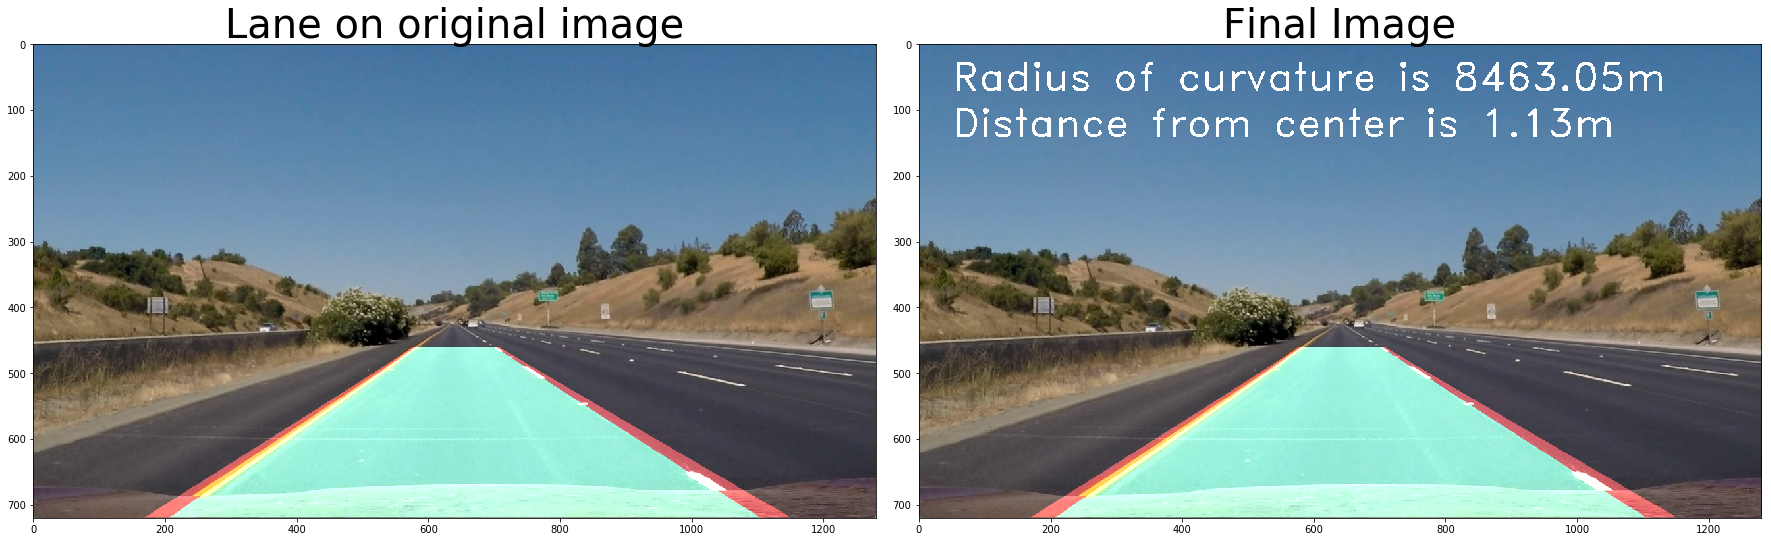

In [19]:
final_image = draw_radius_center(road_lane, R_curve, distance_from_center)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_lane)
ax1.set_title('Lane on original image', fontsize=40)

ax2.imshow(final_image)
ax2.set_title('Final Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 9) Video processing

The pipeline described at the beginning is now used to process the test video and generate the output one.
    1) Undistort image.
    2) Threshold image
    3) Perspective transform
    4) Lines finding
    5) Lane drawing
    6) Warp back the image
    7) Text printing

In [20]:
def pipeline(img):
    # 1 Undistort image
    road_undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # 2 Threshold image
    image_thresholded = combine_threshold(road_undistorted)
    
    # 3 Perspective transform
    warped_image = warp_image(image_thresholded, src_points, dest_points)
    
    # 4 Lines finding
    image_lanes, left_fit, right_fit, ploty, leftx, lefty, rightx, righty = fit_polynomial(warped_image)
    
    # 5 Lane drawing
    warped_lane_drawn = warped_draw_lane(warped_image, left_fit, right_fit, ploty)
    
    # 6 Warp back the image
    lane_drawn = warp_image(warped_lane_drawn, dest_points, src_points)
    road_lane = cv2.addWeighted(img,0.9,lane_drawn,.7,0)
    
    # 7 Text printing
    R_curve = measure_curvature_real(left_fit, right_fit, ploty, leftx, lefty, rightx, righty)
    distance_from_center = measure_distance_from_center(leftx, lefty, rightx, righty, center)
    final_image = draw_radius_center(road_lane, R_curve, distance_from_center)

    return final_image

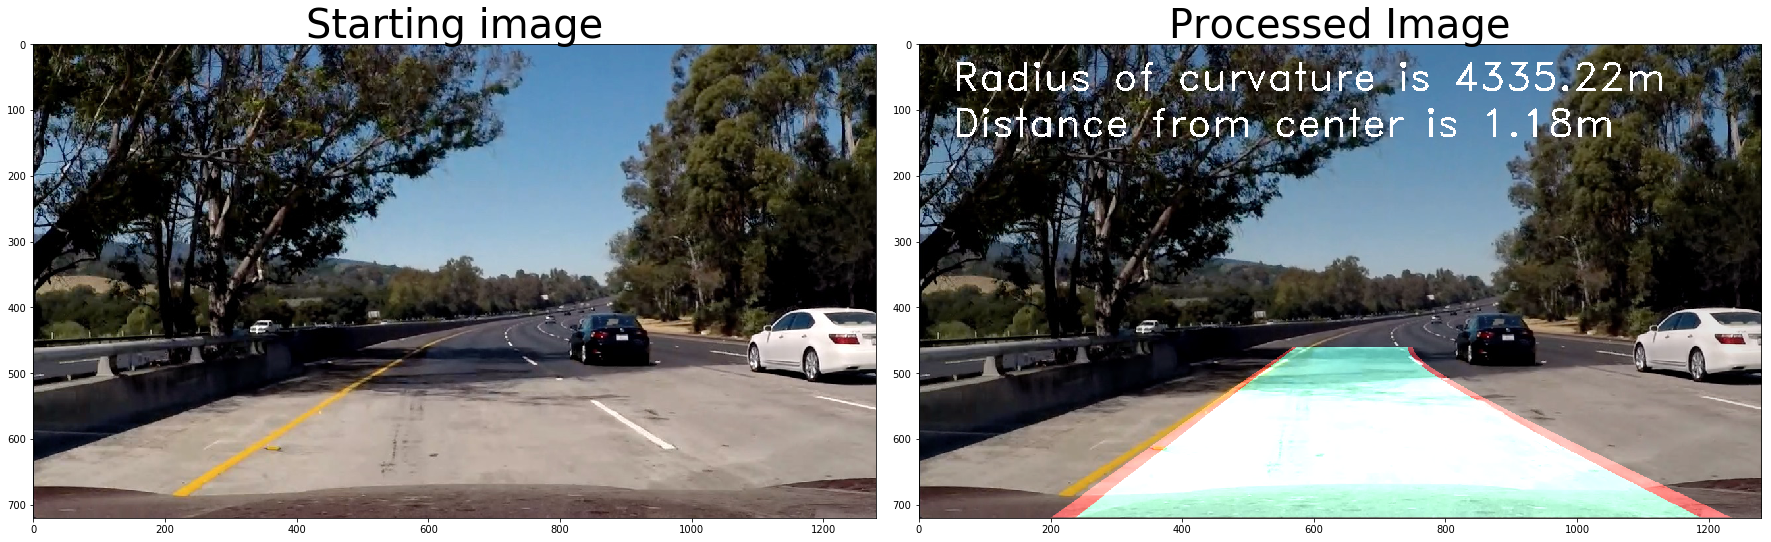

In [21]:
road_distorted = mpimg.imread(glob.glob('test_images/*jpg')[6])
test_output = pipeline(road_distorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_distorted)
ax1.set_title('Starting image', fontsize=40)

ax2.imshow(test_output)
ax2.set_title('Processed Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [22]:
clip = VideoFileClip('project_video.mp4')
clip_annotated = clip.fl_image(pipeline)
%time clip_annotated.write_videofile('output_project_video.mp4', audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [31:24<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 28min 52s, sys: 3.01 s, total: 28min 55s
Wall time: 31min 27s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_project_video.mp4'))